### Imports

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import sys, os
import numpy as np
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import nrrd
import random
from omegaconf import OmegaConf
from typing import Iterable, Dict, Callable, Tuple, Union
from scipy.ndimage import binary_erosion, binary_dilation
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch


sys.path.append('..')
from dataset import EvalDataset
from utils import *
from model import get_model
from user_model import UserModel

### Boiler plate

In [56]:
# Load config
cfg = OmegaConf.load('../configs/eval.yaml')

In [57]:
# Load dataset
dataset = EvalDataset(
    subject_id=784565,
    cfg=cfg, 
    modality='reconstruction',
    to_gpu=False
)

In [58]:
# Update Dataset with annotations
dataset.user = UserModel(dataset.label, 'ground_truth', cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")
cached_annots = dataset.annotations.clone()

number of annotations: 684.0


In [59]:
# Load model
model, state_dict = get_model(
    cfg=cfg,
    return_state_dict=True
)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
# Extract features from model
f_layer = 'encoder'
# Init the feature extractor. Have a look at PyTorchs Hook functionality.
extractor = FeatureExtractor(model, layers=[f_layer])
# Cache all features for a dataset and reformat/move to numpy for random forest stuff
hooked_results  = extractor(dataset)
features = hooked_results[f_layer]
features = features.permute(0,2,3,1).numpy()

### Eval Definitions

In [61]:
### Uncertainty measures
def calc_binary_entropy(prob):
    eps = 1e-5
    
    #Edge Cases
    prob = torch.clamp(prob, eps, 1-eps)
    
    return -(prob*torch.log2(prob) + (1-prob)*torch.log2(1-prob))


def uncertainty_entropy(Y_predicted_prob, n_classes, test_mask):
    
    entropy = calc_binary_entropy(Y_predicted_prob)
    entropy_map = torch.zeros((145,145,145, n_classes))
    entropy_map[test_mask  == 1] = entropy.float()
    mean_entropy_map = entropy_map.mean(axis=-1)
    return mean_entropy_map, entropy_map


def uncertainty_sd(train_label, test_mask, n_classes):

    train_label_tensor = torch.from_numpy(train_label)
    annotated_voxels = torch.any(train_label_tensor, dim=-1)
    # per class
    sd_map_per_class = torch.zeros((n_classes, 145,145,145))
    for i in range(n_classes):
        train_label_i = train_label_tensor[:,:,:,i].bool()
        sd = torch.tensor(distance_transform_edt(~train_label_i))
        sd_map_per_class[i, test_mask == 1] = sd[test_mask == 1].float()  
    sd_map_per_class[:, annotated_voxels] = 0 # all values of annotated voxels should be 0
    # all classes
    spatial_distance_map, _ = torch.min(sd_map_per_class, dim=0)
    
    return spatial_distance_map, sd_map_per_class.permute(1,2,3,0)


def uncertainty_fd(train_label, features, test_mask, n_classes):
    
    train_label_tensor = torch.from_numpy(train_label)
    annotated_voxels = torch.any(train_label_tensor, dim=-1)
    brain_mask_tensor = torch.from_numpy(test_mask == 1)
    
    # def compute_anomaly_scores(annotated_features, mask):
    #     iforest = IsolationForest(n_estimators=100, random_state=0, n_jobs=-1).fit(annotated_features)
    #     anomaly_scores = iforest.decision_function(features[mask].reshape(-1, 44))
    #     anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
    #     return torch.from_numpy(1 - anomaly_scores).float()
    
    def compute_anomaly_scores(annotated_features, mask):
        iforest = IsolationForest(n_estimators=100, random_state=0, n_jobs=-1).fit(annotated_features)
        anomaly_scores = iforest.decision_function(features[mask].reshape(-1, 44))
        return anomaly_scores
    
    # all classes
    annotated_features = features[annotated_voxels].reshape(-1, 44)
    brain_na_mask = brain_mask_tensor & ~annotated_voxels
    anomaly_scores_map = torch.zeros((145,145,145))
    anomaly_scores_map[brain_na_mask] = torch.from_numpy(compute_anomaly_scores(annotated_features, brain_na_mask)).float()
    min = anomaly_scores_map.min()
    max = anomaly_scores_map.max()

    anomaly_scores_map = (anomaly_scores_map - min) / (max - min)
    anomaly_scores_map = 1 - anomaly_scores_map
    t = (0 - min) / (max - min)
    t = 1 - t
    
    # per class
    fd_map_per_class = torch.zeros((n_classes, 145,145,145))
    # for i in range(n_classes):
    #     train_label_i = train_label_tensor[:,:,:,i].bool()
    #     annotated_features = features[train_label_i].reshape(-1, 44)
    #     brain_na_mask = brain_mask_tensor & ~train_label_i
    #     fd_map_per_class[i, brain_na_mask == 1] = compute_anomaly_scores(annotated_features, brain_na_mask)
    # fd_map_per_class[:, annotated_voxels] = 0 # all values of annotated voxels should be 0
    # fd_map_per_class -= fd_map_per_class.amin(dim=(1,2,3), keepdim=True)
    # fd_map_per_class /= fd_map_per_class.amax(dim=(1,2,3), keepdim=True)

    return anomaly_scores_map, fd_map_per_class.permute(1,2,3,0), t


def evaluate_RF(
    dataset: Dataset, 
    features: Tensor, 
    cfg: Dict[str, str], 
    uncertainty_measures: List[str], 
    tta=False
)-> Union[Dict[str, float], Tensor]:

                ###############################
                ##### TRAIN RANDOM FOREST #####
                ###############################
                
    train_mask  = dataset.weight.detach().cpu().squeeze().numpy()    #.permute(0,2,3,1).repeat(1,1,1,44).numpy()
    test_mask   = dataset.brain_mask.detach().cpu().numpy()#.unsqueeze(3).repeat(1,1,1,44).numpy()
    train_label = dataset.annotations.detach().cpu().permute(1,2,3,0).numpy()
    test_label  = dataset.label.detach().cpu().permute(1,2,3,0).numpy()
    
    if tta:
        f = np.stack(features, axis=0)  # (n_tta, 145, 145, 145, 44)
        train_m = np.repeat(train_mask[np.newaxis, ...], len(features), axis=0)  # (n_tta, 145, 145, 145)
        test_m = np.repeat(test_mask[np.newaxis, ...], len(features), axis=0)  # (n_tta, 145, 145, 145)
        train_l = np.repeat(train_label[np.newaxis, ...], len(features), axis=0)  # (n_tta, 145, 145, 145, 5)

        X_train = f.reshape((-1, f.shape[-1]))[train_m.reshape(-1) == 1]    # (n_tta*train_voxels, 44)
        X_test = f.reshape((-1, f.shape[-1]))[test_m.reshape(-1) == 1]    # (n_tta*844350, 44)
        Y_train = train_l.reshape((-1, train_l.shape[-1]))[train_m.reshape(-1) == 1]   # (n_tta*train_voxels, 5)
    
    else:
        # Input - Mask voxels that are not labelled before flattening the input
        X_train = features.reshape((-1, features.shape[-1]))[train_mask.reshape(-1) == 1]
        X_test  = features.reshape((-1, features.shape[-1]))[test_mask.reshape(-1)  == 1]
        # Target - Same as above. Mask before flattening
        Y_train = train_label.reshape((-1, train_label.shape[-1]))[train_mask.reshape(-1) == 1]

    Y_test  = test_label.reshape((-1,  train_label.shape[-1]))[test_mask.reshape(-1)  == 1]

    # Init Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=100,
                         bootstrap=True,
                         oob_score=True,
                         random_state=0,
                         n_jobs=-1,
                         max_features="sqrt", # changed from "auto" because auto got removed
                         class_weight="balanced",
                         max_depth=None,
                         min_samples_leaf=cfg["min_samples_leaf"])

    # Train
    clf.fit(X_train, Y_train)
    # predict labels in test mask
    predicted_prob    = clf.predict_proba(X_test)
    Y_predicted_prob  = torch.tensor(np.array([p[:, 1] for p in predicted_prob])).T
    if tta:
        Y_predicted_prob = Y_predicted_prob.reshape((len(features), 844350, 5)).mean(axis=0)
    Y_predicted_label = (Y_predicted_prob > 0.5)*1


                ###############################
                ####### Save Prediction #######
                ###############################
                
    n_classes = len(cfg['data']['labels'])
    prediction = torch.zeros((145,145,145, n_classes))
    prediction.view(-1, n_classes)[test_mask.reshape(-1)  == 1] = Y_predicted_label.float()

                ###############################
                ##### Evaluate Prediction #####
                ###############################

    # Constant for numerical stability
    eps = 1e-5
    # statictics for precision, recall and Dice (f1)
    TP       = (Y_predicted_label * Y_test).sum(axis=0)
    TPplusFP = Y_predicted_label.sum(axis=0)
    TPplusFN = Y_test.sum(axis=0)

    precision = (TP + eps) / (TPplusFP + eps)
    recall    = (TP + eps) / (TPplusFN + eps)
    f1        = (2 * precision * recall + eps) / ( precision + recall  + eps)

    uncertainty_maps = {}
    uncertainty_per_class_maps = {}

    for measure in uncertainty_measures:
        match measure:
            case 'ground-truth':
                continue
            case 'random':
                break
            case 'entropy':
                uncertainty_map, uncertainty_per_class = uncertainty_entropy(Y_predicted_prob, n_classes, test_mask)
                t = 0
            case 'spatial-distance':
                uncertainty_map, uncertainty_per_class = uncertainty_sd(train_label, test_mask, n_classes)
                t = 0
            case 'feature-distance':
                uncertainty_map, uncertainty_per_class, t = uncertainty_fd(train_label, features, test_mask, n_classes)
            case _:
                raise ValueError(f"Uncertainty measure {measure} not implemented")

        uncertainty_maps[measure] = uncertainty_map
        uncertainty_per_class_maps[measure] = uncertainty_per_class.permute(3,0,1,2)

    #TODO: for measure in novelty_scores:

    labels = cfg['data']["labels"]
    scores = {}
    for c in range(len(labels)):
        scores[f"{labels[c]}_precision"] = precision[c].numpy()
        scores[f"{labels[c]}_recall"] = recall[c].numpy()
        scores[f"{labels[c]}_f1"] = f1[c].numpy()

    scores["Avg_prec_tracts"] = precision[1:].mean().numpy()
    scores["Avg_recall_tracts"] = recall[1:].mean().numpy()
    scores["Avg_f1_tracts"] = f1[1:].mean().numpy()
    
    
    return scores, prediction.permute(3,0,1,2), uncertainty_maps, uncertainty_per_class_maps, t

### Experiments

In [65]:
# umap from evaluate_RF
# errmap from evaluate_RF -> prediction + dataset.label
# annot from refinement_annotation
## PARAMS
num_iterations = 3

## VARS
raw_nmaps = []
maps = []
errmaps = []
annots = []
results = []
thresholds = []

preds = {
    'before': [],
    'after': []
}

# Fresh dataset
dataset.user = UserModel(dataset.label, 'ground_truth', cfg)
dataset.init = 'per_class'
# currently, there are no annotations. We can also enforce this with clear_annotations() at any point
dataset.clear_annotation()
# get initial annotations
annot = dataset.initial_annotation(seed=42)
# and update the dataset
dataset.update_annotation(annot)
# print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")
cached_annots = dataset.annotations.clone()
gt = dataset.label.detach().cpu()
# dataset.user = UserModel(dataset.label, 'estimated', cfg)
scores, prediction, uncertainty_maps, uncertainty_per_class_maps, t = evaluate_RF(
    dataset, 
    features, 
    cfg,
    uncertainty_measures=[
        # 'ground-truth',
        'entropy',
        'feature-distance',
    ]
)
thresholds.append(t)
avrg_f1 = scores['Avg_f1_tracts']
print(f'Scores before: {avrg_f1}')
preds['before'].append(prediction.clone())
raw_nmaps.append(uncertainty_maps['feature-distance'].clone())

results.append(scores)

for i in range(num_iterations):

    u_annots, selection = dataset.user.refinement_annotation(
        prediction=prediction,
        #self.label.detach().cpu(),
        annotation_mask=dataset.annotations.detach().cpu(),
        uncertainty_map=uncertainty_per_class_maps['entropy'],
        n_samples=100,
        mode='per_class',
        map_type='per_class', 
        seed=42,
        inverse_class_freq=False
    )


    dataset.update_annotation(u_annots)
    # print(f"number of uncertainty annotations: {u_annots.sum()}")

    scores, prediction, uncertainty_maps, uncertainty_per_class_maps, t = evaluate_RF(
        dataset, 
        features, 
        cfg,
        uncertainty_measures=[
            # 'ground-truth',
            'entropy',
            'feature-distance',
        ]
    )
    thresholds.append(t)
    avrg_f1 = scores['Avg_f1_tracts']
    print(f'Scores before: {avrg_f1}')
    preds['before'].append(prediction.clone())

    nmap = uncertainty_maps['feature-distance'].clone()



    # ######
    raw_nmaps.append(nmap)
    # # recover actual weighting
    # nmap = (nmap - nmap.min()) / (nmap.max() - nmap.min())
    # nmap = 1 - nmap

    ######


    # mask = prediction[1:].any(0)
    # nmap *= mask
    # dataset.user = UserModel(dataset.label, 'ground_truth', cfg)
    # n_annots, selection = dataset.user.refinement_annotation(
    #     prediction=prediction,
    #     #self.label.detach().cpu(),
    #     annotation_mask=dataset.annotations.detach().cpu(),
    #     uncertainty_map=nmap,
    #     n_samples=200,
    #     mode='single_slice',
    #     map_type='per_slice', 
    #     seed=42,
    #     inverse_class_freq=False
    # )    

    # dataset.update_annotation(n_annots)
    # print(f"number of novelty annotations: {n_annots.sum()}")
    # print(f"number of annotations: {dataset.annotations.detach().cpu().sum()}")
    # collect
    errmap = torch.any((prediction != gt) * dataset.brain_mask.detach().cpu(), dim=0)
    # maps.append(nmap[selection[1:]])
    # annots.append(n_annots.any(0)[selection[1:]])
    errmaps.append(errmap[selection[1:]])

# scores, prediction, uncertainty_maps, uncertainty_per_class_maps, t = evaluate_RF(
#     dataset, 
#     features, 
#     cfg, 
#     uncertainty_measures=[
#         # 'ground-truth', 
#         # 'entropy', 
#         'feature-distance', 
#     ]
# )
# preds['after'].append(prediction.clone())
# errmap = torch.any((prediction != gt) * dataset.brain_mask.detach().cpu(), dim=0)
# # avrg_f1 = scores['Avg_f1_tracts']
# # print(f'Scores after: {avrg_f1}')
# results.append(scores)
# thresholds.append(t)
# nmap = uncertainty_maps['feature-distance'].clone()
# raw_nmaps.append(nmap)

Scores before: 0.37279602384250804
Scores before: 0.4486248145170181
Scores before: 0.4696605224169542
Scores before: 0.48624584790513714


In [83]:
p = preds['before'][0].clone()
m = raw_nmaps[0].clone()
dicts = []
threshold = thresholds[0]

In [78]:
p[:, m>threshold] = torch.tensor([1, 0, 0, 0, 0])[:, None].float()

In [80]:
test1 =  torch.zeros((5, 145, 145, 145))

test1[:, m>0]=torch.tensor([1, 0, 0, 0, 0])[:, None].float()

print(test1.sum((1,2,3)))


tensor([3048624.,       0.,       0.,       0.,       0.])


In [103]:
def add_background_bias(
    prediction: Tensor,
    anomaly_score_map: Tensor,
    background_class: Tensor,
    threshold: float
):
    # Check inputs
    assert prediction.shape[1:] == anomaly_score_map.shape
    assert len(prediction.shape) == 4
    assert len(background_class) == prediction.shape[0], f"{background_class.shape} != {prediction.shape[0]}"
    assert threshold >= 0 and threshold <= 1

    # Add background bias
    prediction[:, anomaly_score_map>threshold] = background_class[:, None].float()

    return prediction

In [102]:
assert len(torch.tensor([1, 0, 0, 0, 0])) == p.shape[0]

In [104]:
test1 = add_background_bias(
    prediction=p,
    anomaly_score_map=m,
    background_class=torch.tensor([1, 0, 0, 0, 0]),
    threshold=threshold
)

In [105]:
test1.shape

torch.Size([5, 145, 145, 145])

In [69]:
# p = preds['before'][0].clone().flatten(1)
# m = raw_nmaps[0].clone().flatten()
# dicts = []
# threshold = thresholds[0]

def f1(
    pred, 
    gt,
    cfg
):
    # Constant for numerical stability
    eps = 1e-5
    # statictics for precision, recall and Dice (f1)
    TP       = (pred * gt).sum(axis=0)
    TPplusFP = pred.sum(axis=0)
    TPplusFN = gt.sum(axis=0)

    precision = (TP + eps) / (TPplusFP + eps)
    recall    = (TP + eps) / (TPplusFN + eps)
    f1        = (2 * precision * recall + eps) / ( precision + recall  + eps)
    
    labels = cfg['data']["labels"]
    scores = {}
    for c in range(len(labels)):
        scores[f"{labels[c]}_precision"] = precision[c].numpy()
        scores[f"{labels[c]}_recall"] = recall[c].numpy()
        scores[f"{labels[c]}_f1"] = f1[c].numpy()

    scores["Avg_prec_tracts"] = precision[1:].mean().numpy()
    scores["Avg_recall_tracts"] = recall[1:].mean().numpy()
    scores["Avg_f1_tracts"] = f1[1:].mean().numpy()

    return f1


original_f1 = [0.37193363084047804, 0.46406966608597766, 0.5141518150203289, 0.5422143511977355]
dicts = [{} for _ in range(4)]


for m, threshold, pre, dct in zip(raw_nmaps, thresholds, preds['before'], dicts):
    m = m.clone().flatten()

    p = pre.clone().flatten(1)
    p[:, m>threshold] = torch.tensor([1, 0, 0, 0, 0])[:, None].float()

    dice = f1(p[1:].T, gt[1:].flatten(1).T)
    dct[threshold.data] = dice.mean().item()

    
    for t in torch.linspace(1, 0.3, 8):
        p = pre.clone().flatten(1)
        p[:, m>t] = torch.tensor([1, 0, 0, 0, 0])[:, None].float()

        dice = f1(p[1:].T, gt[1:].flatten(1).T)

        dct[t.data] = dice.mean().item()
        
print(dicts)


[{tensor(0.4095): 0.3944535553455353, tensor(1.): 0.3726629614830017, tensor(0.9000): 0.37271517515182495, tensor(0.8000): 0.3731178641319275, tensor(0.7000): 0.3753123879432678, tensor(0.6000): 0.38012558221817017, tensor(0.5000): 0.38876014947891235, tensor(0.4000): 0.3873956501483917, tensor(0.3000): 0.3732820749282837}, {tensor(0.4149): 0.4549497365951538, tensor(1.): 0.4484848976135254, tensor(0.9000): 0.44847333431243896, tensor(0.8000): 0.4484490752220154, tensor(0.7000): 0.4494779109954834, tensor(0.6000): 0.4515193700790405, tensor(0.5000): 0.4543335437774658, tensor(0.4000): 0.44592177867889404, tensor(0.3000): 0.4327937364578247}, {tensor(0.4075): 0.4755173921585083, tensor(1.): 0.4694962501525879, tensor(0.9000): 0.46948879957199097, tensor(0.8000): 0.4694489538669586, tensor(0.7000): 0.46969401836395264, tensor(0.6000): 0.4702504277229309, tensor(0.5000): 0.47115305066108704, tensor(0.4000): 0.4661269187927246, tensor(0.3000): 0.4590275287628174}, {tensor(0.4184): 0.490130

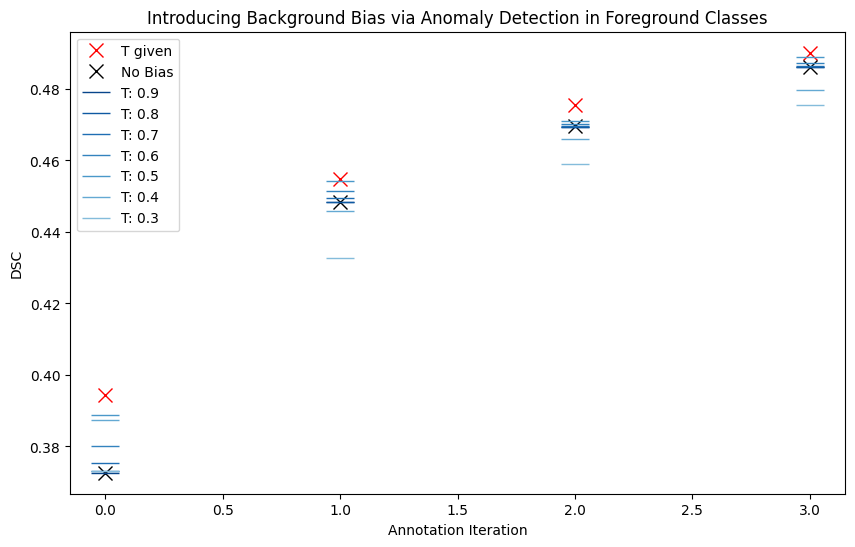

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Your list of dictionaries
# data = [
#     {0.3921: 0.4011942744255066, 1.0: 0.3717939555644989, 0.9: 0.3718118369579315, 0.8: 0.3722378611564636, 0.7: 0.37473005056381226, 0.6: 0.3818221092224121, 0.5: 0.3916214108467102, 0.4: 0.40098118782043457, 0.3: 0.38709312677383423, 0.2: 0.3423919677734375, 0.1: 0.1983565092086792, 0.0: 1.0003594070440158e-05}, 
#     {0.4167: 0.47976967692375183, 1.0: 0.4639327824115753, 0.9: 0.4639240801334381, 0.8: 0.46390169858932495, 0.7: 0.4647374451160431, 0.6: 0.4673839807510376, 0.5: 0.47626960277557373, 0.4: 0.46467962861061096, 0.3: 0.45717281103134155, 0.2: 0.40694767236709595, 0.1: 0.22398771345615387, 0.0: 1.0003594070440158e-05}, 
#     {0.4309: 0.5178563594818115, 1.0: 0.5139825940132141, 0.9: 0.5139766931533813, 0.8: 0.5139925479888916, 0.7: 0.5144129395484924, 0.6: 0.5153756141662598, 0.5: 0.5171371698379517, 0.4: 0.5005598664283752, 0.3: 0.4891539514064789, 0.2: 0.4415915012359619, 0.1: 0.26971158385276794, 0.0: 1.2647559742617887e-05}, 
#     {0.4052: 0.5440102815628052, 1.0: 0.5420596599578857, 0.9: 0.5420498251914978, 0.8: 0.5419927835464478, 0.7: 0.5421596765518188, 0.6: 0.5427266955375671, 0.5: 0.5426525473594666, 0.4: 0.522631824016571, 0.3: 0.5109505653381348, 0.2: 0.46384096145629883, 0.1: 0.2954111397266388, 0.0: 0.12500780820846558}
# ]

data = dicts

# Prepare the figure
plt.figure(figsize=(10, 6))

# Iterate over each dictionary in the list
for idx, d in enumerate(data):
    keys = list(d.keys())
    values = list(d.values())
    
    # Sort by key values to ensure gradient is applied correctly
    # sorted_keys = sorted(keys)
    # sorted_values = [d[k] for k in sorted_keys]
    
    # Prepare colors
    colors = ['red', 'black'] + [plt.cm.Blues(0.2 + 0.8 * (k / max(keys))) for k in keys[2:]]

    # Plot each value
    for k, v, color in zip(keys, values, colors):
        if color == 'red':
            if idx == 0:
                plt.plot(idx, v, 'x', color=color,  markersize=10, label=f'T given')
            else:
                plt.plot(idx, v, 'x', color=color,  markersize=10)
        elif color == 'black':
            if idx == 0:
                plt.plot(idx, v, 'x', color=color,  markersize=10, label='No Bias')
            else:
                plt.plot(idx, v, 'x', color=color,  markersize=10)
        else:
            if idx == 0:
                plt.plot(idx, v, '_', color=color, markersize=20, label=f'T: {k:.1f}')
            else:
                plt.plot(idx, v, '_', color=color, markersize=20)

# Set labels and title
plt.xlabel('Annotation Iteration')
plt.ylabel('DSC')
plt.title('Introducing Background Bias via Anomaly Detection in Foreground Classes')
plt.legend()

# Show the plot
plt.savefig('../../results/background_bias.png', )


/tmp/ipykernel_1944325/3489226232.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='index', y='value', data=df, inner=None, palette=colors)
/tmp/ipykernel_1944325/3489226232.py:31: UserWarning: The palette list has more values (48) than needed (4), which may not be intended.
  sns.violinplot(x='index', y='value', data=df, inner=None, palette=colors)


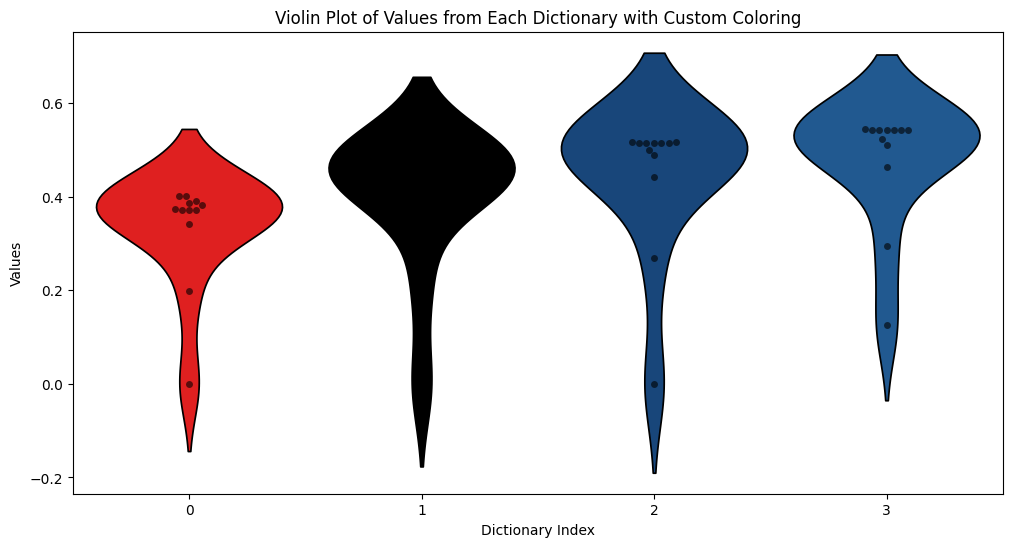

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your list of dictionaries
data = [
    {0.3921: 0.4011942744255066, 1.0: 0.3717939555644989, 0.9: 0.3718118369579315, 0.8: 0.3722378611564636, 0.7: 0.37473005056381226, 0.6: 0.3818221092224121, 0.5: 0.3916214108467102, 0.4: 0.40098118782043457, 0.3: 0.38709312677383423, 0.2: 0.3423919677734375, 0.1: 0.1983565092086792, 0.0: 1.0003594070440158e-05}, 
    {0.4167: 0.47976967692375183, 1.0: 0.4639327824115753, 0.9: 0.4639240801334381, 0.8: 0.46390169858932495, 0.7: 0.4647374451160431, 0.6: 0.4673839807510376, 0.5: 0.47626960277557373, 0.4: 0.46467962861061096, 0.3: 0.45717281103134155, 0.2: 0.40694767236709595, 0.1: 0.22398771345615387, 0.0: 1.0003594070440158e-05}, 
    {0.4309: 0.5178563594818115, 1.0: 0.5139825940132141, 0.9: 0.5139766931533813, 0.8: 0.5139925479888916, 0.7: 0.5144129395484924, 0.6: 0.5153756141662598, 0.5: 0.5171371698379517, 0.4: 0.5005598664283752, 0.3: 0.4891539514064789, 0.2: 0.4415915012359619, 0.1: 0.26971158385276794, 0.0: 1.2647559742617887e-05}, 
    {0.4052: 0.5440102815628052, 1.0: 0.5420596599578857, 0.9: 0.5420498251914978, 0.8: 0.5419927835464478, 0.7: 0.5421596765518188, 0.6: 0.5427266955375671, 0.5: 0.5426525473594666, 0.4: 0.522631824016571, 0.3: 0.5109505653381348, 0.2: 0.46384096145629883, 0.1: 0.2954111397266388, 0.0: 0.12500780820846558}
]

# Prepare data for plotting
plot_data = []
colors = []
for idx, d in enumerate(data):
    for i, (k, v) in enumerate(d.items()):
        plot_data.append({'index': idx, 'value': v})
        if i == 0:
            colors.append('red')
        elif i == 1:
            colors.append('black')
        else:
            colors.append(plt.cm.Blues(0.2 + 0.8 * k))

# Convert to DataFrame
df = pd.DataFrame(plot_data)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.violinplot(x='index', y='value', data=df, inner=None, palette=colors)
sns.swarmplot(x='index', y='value', data=df, color='k', alpha=0.6)  # Add a swarm plot to show individual points

plt.xlabel('Dictionary Index')
plt.ylabel('Values')
plt.title('Violin Plot of Values from Each Dictionary with Custom Coloring')

plt.show()


In [105]:
0.50120857 
0.52803354
0.54399739
0.55581491
0.56501592

[{tensor(1.): 0.5010831356048584},
 {tensor(0.9000): 0.5010792016983032},
 {tensor(0.8000): 0.5012274980545044},
 {tensor(0.7000): 0.5014948844909668},
 {tensor(0.6000): 0.5017366409301758},
 {tensor(0.5000): 0.5029430389404297},
 {tensor(0.4000): 0.502671480178833},
 {tensor(0.3000): 0.4739152193069458},
 {tensor(0.2000): 0.4253828525543213},
 {tensor(0.1000): 0.2620338499546051},
 {tensor(0.): 0.12500938773155212},
 {tensor(0.3788): 0.5013114213943481}]

In [80]:
(m>t).sum()

tensor(36)

In [85]:
torch.tensor([[1, 0, 0, 0, 0]]).shape

torch.Size([1, 5])

(array([5.0000e+00, 4.0000e+00, 6.0000e+00, 6.0000e+00, 3.8000e+01,
        5.8000e+01, 6.4000e+01, 1.0500e+02, 1.0800e+02, 1.5100e+02,
        1.6200e+02, 1.8700e+02, 2.1300e+02, 2.8900e+02, 3.6000e+02,
        4.9300e+02, 5.1100e+02, 5.3800e+02, 5.6900e+02, 6.9500e+02,
        8.0600e+02, 9.1400e+02, 9.7300e+02, 1.0940e+03, 1.2950e+03,
        1.3590e+03, 1.4830e+03, 1.7150e+03, 1.9300e+03, 2.0100e+03,
        2.1850e+03, 2.4170e+03, 2.6850e+03, 2.8270e+03, 3.0420e+03,
        3.1160e+03, 3.4140e+03, 3.6170e+03, 3.5930e+03, 3.9750e+03,
        4.1000e+03, 4.5510e+03, 4.8190e+03, 5.0890e+03, 5.3150e+03,
        5.4060e+03, 5.6680e+03, 5.8320e+03, 6.1640e+03, 6.3610e+03,
        6.5830e+03, 6.7430e+03, 6.9890e+03, 7.2760e+03, 7.4320e+03,
        7.9800e+03, 8.0780e+03, 8.5380e+03, 8.9290e+03, 9.3310e+03,
        9.5170e+03, 1.0090e+04, 1.0352e+04, 1.0655e+04, 1.0910e+04,
        1.1300e+04, 1.1785e+04, 1.2125e+04, 1.2457e+04, 1.2712e+04,
        1.3210e+04, 1.3688e+04, 1.4574e+04, 1.51

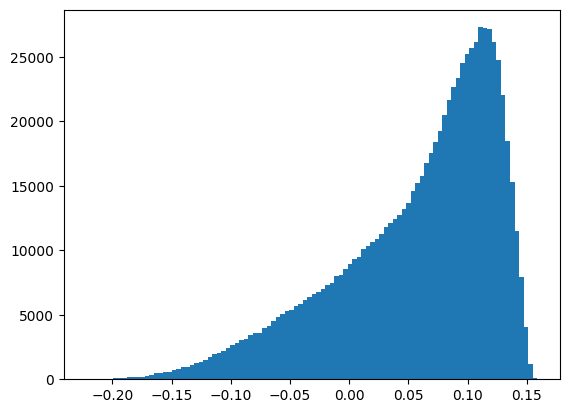

In [23]:
plt.hist(raw_nmaps[0].flatten(), bins=100)